Import all dependencies

In [289]:
from typing import Dict, Tuple
from matplotlib import pyplot as plt
import numpy as np
import cv2

Helper functions for displaying images

In [290]:
def show_image(img: np.ndarray, window_name: str) -> None:
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(window_name)
    plt.show()

def show_subplot(named_imgs: Dict[str, np.ndarray], max_size=32) -> None:
    f, axarr = plt.subplots(1, len(named_imgs))
    f.set_figheight(max_size)
    f.set_figwidth(max_size)

    for idx, (name, img) in enumerate(named_imgs.items()):
        if (img.ndim == 2):
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        axarr[idx].set_title(name)
        axarr[idx].imshow(img)

Default kernels

In [291]:
kernel_sobel_left = np.array([[ 1,  0, -1], 
                              [ 2,  0, -2], 
                              [ 1,  0, -1]], np.float32)

kernel_sobel_top  = np.array([[ 1,  2,  1], 
                              [ 0,  0,  0], 
                              [-1, -2,  -1]], np.float32)

kernel_ridge      = np.array([[-1, -1, -1], 
                              [-1,  8, -1], 
                              [-1, -1, -1]], np.float32)

kernel_sharpen    = np.array([[ 0, -1,  0], 
                              [-1,  5, -1], 
                              [ 0, -1,  0]], np.float32)

kernel_blur_3     = np.array([[ 1,  2,  1], 
                              [ 2,  4,  2], 
                              [ 1,  2,  1]], np.float32)
kernel_blur_3 /= kernel_blur_3.sum()

kernel_blur_5     = np.array([[1,  4,  6,  4,  1], 
                              [4, 16, 24, 16,  4], 
                              [6, 24, 36, 24,  6],
                              [4, 16, 24, 16,  4],
                              [1,  4,  6,  4,  1]], np.float32)
kernel_blur_5 /= kernel_blur_5.sum()

Load the base image

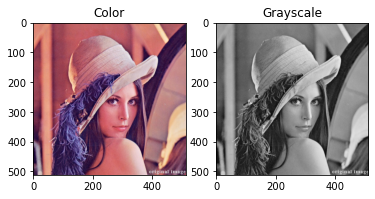

In [292]:
raw_img = cv2.imread('imgs/lena_color.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
bw_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2GRAY)
bw_img = bw_img.astype(np.float32)
bw_img /= 255.

show_subplot({"Color": raw_img, "Grayscale": bw_img}, 6)

Create function for generating convolutions

In [293]:
def dist_to_kernel_center(k_size: int, x: int, y: int) -> Tuple[int, int]:
    target = int(k_size/2) + 1
    out_x = target - (x+1)
    out_y = target - (y+1)

    return out_x, out_y

def convolve(img: np.ndarray, kernel: np.ndarray, normalize=True) -> np.ndarray:
    out_img = np.zeros(img.shape, np.float32)
    imgH = img.shape[0]
    imgW = img.shape[1]

    for img_y in range(imgH):
        for img_x in range(imgW):
            for ker_y in range(kernel.shape[0]):
                for ker_x in range(kernel.shape[1]):
                    output_offset_x, output_offset_y = dist_to_kernel_center(kernel.shape[0], ker_x, ker_y)
                    if (img_x+ker_x >= imgW): continue
                    if (img_y+ker_y >= imgH): continue
                    if (img_x+output_offset_x >= imgW): continue
                    if (img_y+output_offset_y >= imgH): continue

                    px_out = img[img_y+ker_y, img_x+ker_x] * kernel[ker_y, ker_x]
                    out_img[img_y+output_offset_y, img_x+output_offset_x] += px_out

    if (normalize):
        norm_neg = sum(x for x in kernel.ravel() if x < 0)
        norm_pos = sum(x for x in kernel.ravel() if x > 0)
        out_img = (out_img - norm_neg) / (norm_pos - norm_neg)

    return out_img

Generate and display various convolutions 

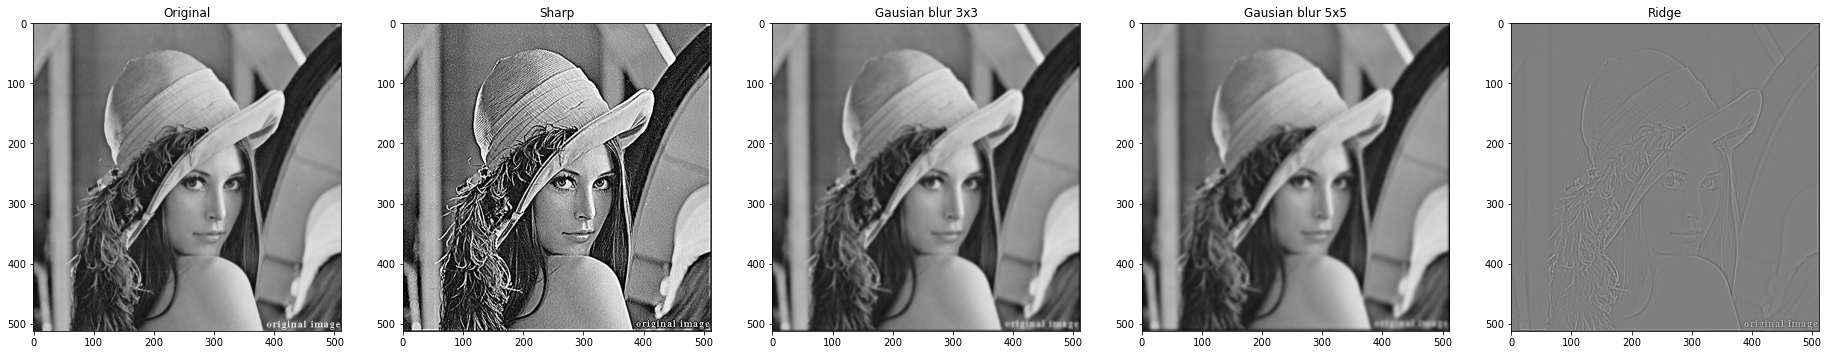

In [294]:
img_ridge = convolve(bw_img, kernel_ridge)
img_sharpen = np.clip(convolve(bw_img, kernel_sharpen, False), 0, 1)
img_blur3 = convolve(bw_img, kernel_blur_3)
img_blur5 = convolve(bw_img, kernel_blur_5)

show_subplot({'Original': bw_img, 'Sharp': img_sharpen, 'Gausian blur 3x3': img_blur3, 'Gausian blur 5x5': img_blur5, 'Ridge': img_ridge})

Generate the sobel from top and left filters

In [295]:
img_sobel_top = convolve(img_blur3, kernel_sobel_top, False)
img_sobel_left = convolve(img_blur3, kernel_sobel_left, False)
img_sobel = np.hypot(img_sobel_top, img_sobel_left)
theta = np.arctan2(img_sobel_top, img_sobel_left)

Use non-max suppression as the thinning algorithm

In [296]:
def non_max_suppression(img: np.ndarray, theta: np.ndarray) -> np.ndarray:
    out_img = np.zeros(img.shape, np.float32)
    imgH = img.shape[0]
    imgW = img.shape[1]
    angle = theta * 180. / np.pi # Convert radians to degrees
    angle[angle < 0] += 180 # Make range 0 to 180 instead of -180 to 180


    for img_y in range(1, imgH-1):
        for img_x in range(1, imgW-1):
            px_before = 0.
            px_after = 0.
            curr_angle = angle[img_y, img_x]

            #angle 0
            if (0 <= curr_angle < 22.5) or (157.5 <= curr_angle <= 180):
                px_before = img[img_y, img_x-1]
                px_after = img[img_y, img_x+1]
            #angle 45
            elif (22.5 <= curr_angle < 67.5):
                px_before = img[img_y-1, img_x+1]
                px_after = img[img_y+1, img_x-1]
            #angle 90
            elif (67.5 <= curr_angle < 112.5):
                px_before = img[img_y-1, img_x]
                px_after = img[img_y+1, img_x]
            #angle 135
            elif (112.5 <= curr_angle < 157.5):
                px_before = img[img_y-1, img_x-1]
                px_after = img[img_y+1, img_x+1]

            if (img[img_y, img_x] >= px_before) and (img[img_y, img_x] >= px_after):
                out_img[img_y, img_x] = img[img_y, img_x]
            else:
                out_img[img_y, img_x] = 0

    return out_img

Thin the image and show the image steps 

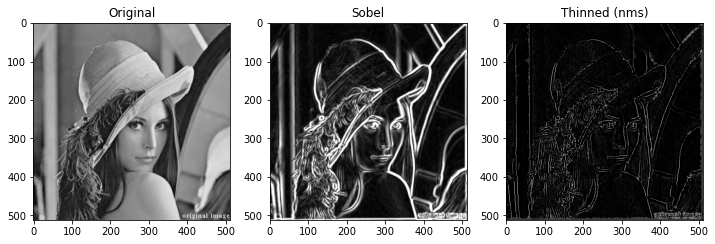

In [297]:
img_nms = non_max_suppression(img_sobel, theta)

show_subplot({'Original': bw_img, 'Sobel': np.clip(img_sobel, 0, 1), 'Thinned (nms)': np.clip(img_nms, 0, 1)}, 12)

Do upper and lower threshold